In [51]:
import pandas as pd
import re
import random
from psm_utils.psm import PSM
from psm_utils.psm_list import PSMList
from psm_utils.io import write_file
from pathlib import Path
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from deeplc import DeepLC
import rustyms
import seaborn as sns
import matplotlib.pyplot as plt
import math

project_root = Path.cwd().parent

sys.path.append(str(project_root))

from make_predictions.intensity_predictions import obtain_predictions_pairs
from seq_utils.fasta_to_peptides import create_tryptic_peptides
from seq_utils.peptide import (
    remove_non_il,
    remove_ux_containing,
    switch_first_il,
    switch_random_il,
    has_il_outside_brackets,
    get_proforma_bracketed,
)
from metrics.get_metrics import metrics_comparison

from matplotlib import pyplot as plt
from IPython.display import display

In [3]:
%matplotlib inline

In [4]:
fraction = 0.5
random_seed = 42

df = pd.read_csv("../temp_data/input_file.txt", sep="\t") # MQ search
df = df[df["Sequence"].str.len() < 30]

parse_column = "Modified sequence"
before_aa = False
isalpha = True
isupper = True
pattern = "\\([^()]*\\)|\\([^()]*\\([^()]*\\)[^()]*\\)"
modification_dict = {"(ox)" : "UNIMOD:35", "(ac)" : "UNIMOD:1", "(oxidation (m))" : "UNIMOD:35", "(acetyl (protein n-term))" : "UNIMOD:1"}


df["proforma"] = df["Modified sequence"].apply(
    get_proforma_bracketed,
    before_aa=before_aa,
    isalpha=isalpha,
    isupper=isupper,
    pattern=pattern,
    modification_dict=modification_dict,
)
df = df[~np.isnan(df["MS/MS scan number"])]

In [5]:
import os
from pyteomics import mgf

def parse_mgf_with_pyteomics(file_path):
    """
    Parses an MGF file using pyteomics into a nested dictionary.
    
    Parameters:
    - file_path (str): Path to the MGF file.
    
    Returns:
    - dict: {filename: {scan_number: spectrum_data}}
    """
    filename = os.path.splitext(os.path.basename(file_path))[0]
    spectra = {}

    with mgf.read(file_path) as reader:
        for spectrum in tqdm(reader):
            # Retrieve scan number, defaulting to 0 if not present
            scan_str = spectrum.get('params', {}).get('scans')
            if scan_str is not None:
                try:
                    scan_number = int(scan_str)
                except ValueError:
                    scan_number = 0
            else:
                scan_number = 0
            
            # Store both metadata and m/z-intensity pairs
            spectra[scan_number] = {
                'params': spectrum.get('params', {}),
                'm/z array': spectrum.get('m/z array', []),
                'intensity array': spectrum.get('intensity array', [])
            }
    return {filename: spectra}

# Example usage
files = [
    "../temp_data/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf",
    "../temp_data/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02.mgf",
    "../temp_data/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03.mgf",
    "../temp_data/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01.mgf",
    "../temp_data/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02.mgf",
    "../temp_data/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03.mgf",
]

mgf_dict = {}
for f in files:
    result = parse_mgf_with_pyteomics(f)
    mgf_dict.update(result)

100%|██████████| 118174/118174 [00:14<00:00, 8009.25it/s] 


In [6]:
peptides = np.array(df["proforma"])
peptides_switched = np.array([switch_random_il(peptide) for peptide in peptides])

In [7]:
peptides_switch_predictions_f = "../temp_data/peptides_switch_predictions_puyvelde.csv"
peptides_predictions_f = "../temp_data/peptides_predictions_puyvelde.csv"

batch_size = 5000
peptides_switch_predictions_list = []
peptides_predictions_list = []

# TODO move this to make_predictions.intensity_predictions
def safe_obtain_predictions(peptides_batch, switched, max_retries=3, delay=1):
    """
    Attempts to obtain predictions for a batch of peptides, retrying in case of failure.

    Args:
        peptides_batch (list): List of peptide sequences.
        switched (bool): Parameter for prediction function.
        max_retries (int): Maximum number of retries before raising the exception.
        delay (int): Delay in seconds between retries.

    Returns:
        pd.DataFrame: DataFrame of predictions.
    """
    for attempt in range(max_retries):
        try:
            return obtain_predictions_pairs(peptides_batch, switched=switched, model="Prosit_2024_intensity_PTMs_gl")
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                raise RuntimeError(
                    f"Prediction failed after {max_retries} attempts."
                ) from e

if os.path.exists(peptides_switch_predictions_f) and os.path.exists(
    peptides_predictions_f
):
    peptides_switch_predictions = pd.read_csv(peptides_switch_predictions_f)
    peptides_predictions = pd.read_csv(peptides_predictions_f)
else:
    for i in tqdm(range(0, len(peptides), batch_size)):
        batch_switched = peptides_switched[i : i + batch_size]
        batch = peptides[i : i + batch_size]

        peptides_switch_predictions_list.append(
            safe_obtain_predictions(batch_switched, switched=True)
        )
        peptides_predictions_list.append(
            safe_obtain_predictions(batch, switched=False)
        )

    peptides_switch_predictions = pd.concat(
        peptides_switch_predictions_list,
        ignore_index=True
    )
    peptides_predictions = pd.concat(
        peptides_predictions_list, 
        ignore_index=True
    )

    peptides_switch_predictions.to_csv(
        peptides_switch_predictions_f,
        index=False,
    )
    peptides_predictions.to_csv(
        peptides_predictions_f, 
        index=False
    )

In [8]:
df_orig_to_swap = pd.DataFrame(np.array([peptides,peptides_switched])).T
df_orig_to_swap.index = df_orig_to_swap.iloc[:,0]
dict_orig_to_swap = df_orig_to_swap.to_dict()[1]

In [9]:
import re

def get_df_annotated_spectrum(annotated_spectrum):
    matched_fragments = []
    for sp in annotated_spectrum.spectrum:
        try:
            string_repr_rustyms = repr(sp.annotation[0])
        except:
            continue
        ion_match = re.search(r"ion='([^']*)'", string_repr_rustyms)
        ion_value = ion_match.group(1)
        charge_match = re.search(r"charge=([^']*),", string_repr_rustyms)
        charge_value = charge_match.group(1)
        matched_fragments.append((ion_value, charge_value, sp.intensity))
    return pd.DataFrame(matched_fragments,columns=["ion", "charge", "intensity"])

In [10]:
# Group by peptide_sequences and store each group DataFrame in a dict
dict_predictions = dict(tuple(peptides_predictions.groupby("peptide_sequences")))
dict_predictions_switched = dict(tuple(peptides_switch_predictions.groupby("peptide_sequences")))

In [11]:
dict_il_intensity = {}

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    raw_spectrum = rustyms.RawSpectrum(
        title="spectrum_1",
        num_scans=6,
        rt=10,
        precursor_mass=436.12634,
        precursor_charge=2,
        mz_array=mgf_dict[row["Raw file"]][int(row['MS/MS scan number'])]["m/z array"],
        intensity_array=mgf_dict[row["Raw file"]][int(row['MS/MS scan number'])]['intensity array'],
    )

    peptide = rustyms.CompoundPeptidoform(row['proforma'] + "/" + str(row['Charge']))

    annotated_spectrum = raw_spectrum.annotate(peptide, rustyms.FragmentationModel.CidHcd)

    df_annotation = get_df_annotated_spectrum(annotated_spectrum)

    swap_sequence = dict_orig_to_swap[row['proforma']]
    sub_df_predictions = dict_predictions.get(row['proforma'])
    if sub_df_predictions is None:
        continue

    sub_df_predictions_switched = dict_predictions_switched.get(swap_sequence)
    if sub_df_predictions_switched is None:
        continue

    
    sub_df_predictions[['ion', 'charge']] = sub_df_predictions['annotation'].str.extract(r"([a-zA-Z]+\d+)\+(\d+)")
    sub_df_predictions['charge'] = sub_df_predictions['charge'].astype(int)
    sub_df_predictions_switched[['ion', 'charge']] = sub_df_predictions_switched['annotation'].str.extract(r"([a-zA-Z]+\d+)\+(\d+)")
    sub_df_predictions_switched['charge'] = sub_df_predictions_switched['charge'].astype(int)

    df_annotation['charge'] = df_annotation['charge'].astype(int)
    
    merged = pd.merge(df_annotation, sub_df_predictions, on=['ion', 'charge'], how='inner')
    merged_all = pd.merge(merged, sub_df_predictions_switched, on=['ion', 'charge'], how='inner')
    merged_all.drop_duplicates(inplace=True)

    try:
        dict_il_intensity[row['proforma']] = {
            "intensity_obs": merged_all["intensity"].values,
            "intensity_obs_norm": merged_all["intensity"].values/max(merged_all["intensity"].values),
            "intensities_orig": merged_all["intensities_x"].values,
            "intensities_swapped": merged_all["intensities_y"].values,
            "mz_orig" : merged_all["mz_x"].values,
            "mz_swapped" : merged_all["mz_y"].values, 
            "seq": merged_all["peptide_sequences_x"].values,
            "seq_swapped": merged_all["peptide_sequences_y"].values,
        }
    except ValueError:
        # Max seems to crash with empty arrays, so we skip those
        continue

Processing rows:   0%|          | 0/196947 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 196947/196947 [17:01<00:00, 192.87it/s] 


In [12]:
merged_all

,ion,charge,intensity,peptide_sequences_x,precursor_charges_x,collision_energies_x,instrument_types_x,fragmentation_types_x,intensities_x,mz_x,...,non_switched_x,peptide_sequences_y,precursor_charges_y,collision_energies_y,instrument_types_y,fragmentation_types_y,intensities_y,mz_y,annotation_y,non_switched_y
0,y1,1,145906.078,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.077793,175.11896,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.077793,175.11896,y1+1,True
36,b2,1,486801.094,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.184219,185.09207,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.184219,185.09207,b2+1,True
72,y2,1,49753.090,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.045691,232.14041,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.045691,232.14041,y2+1,True
108,b3,1,1188605.750,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.670184,256.12918,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.670184,256.12918,b3+1,True
144,y3,1,198956.219,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.220258,289.16187,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.220258,289.16187,y3+1,True
180,b4,1,1491087.625,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.887435,327.16630,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.887435,327.16630,b4+1,True
216,y4,1,161362.375,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.169438,360.19900,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.169438,360.19900,y4+1,True
252,b5,1,1336410.500,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,1.000000,398.20340,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,1.000000,398.20340,b5+1,True
288,y5,1,172888.891,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.177623,431.23610,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.177623,431.23610,y5+1,True
324,b6,1,1068377.750,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.941950,469.24050,...,False,[UNIMOD:1]-AAAAAAAAAAGAAGGR,2,28,LUMOS,HCD,0.941950,469.24050,b6+1,True


In [48]:
import numpy as np
import pandas as pd
import metrics.metrics as M

metric_keys = [
    m for m in dir(M) if ((m[:2] != "__") & (m != "binarize") & (m != "normalize"))
]
metric_keys = [
    "mse",
    "pearson_correlation",
    "spearman_correlation",
    "dot_product",
    "mara_similarity",
    "modified_dot_product",
    "massbank_score",
    "gnps_score",
    "stein_scott_score",
    "wasserstein",
    "kendall_tau",
    "mutual_information",
    "bray_curtis",
    "canberra_distance",
    "mara_weighted_similarity",
    "diagnostic_weighted_similarity",
]


scored_dict_seqs = {}
for seq,frag_intensities in tqdm(dict_il_intensity.items()):
    score_dict = {}
    for key in metric_keys:
        inp = {
            "intensity1": frag_intensities["intensity_obs_norm"],
            "intensity2": frag_intensities["intensities_orig"],
            "mz1": frag_intensities["mz_orig"],
            "mz2": frag_intensities["mz_orig"],
            "diagnostic_mz": np.array([]),
            "mz": max(frag_intensities["mz_orig"]),
        }

        try:
            score = getattr(M, key)(**inp)
        except Exception as e:
            score = np.nan

        inp_swapped = {
            "intensity1": frag_intensities["intensity_obs_norm"],
            "intensity2": frag_intensities["intensities_swapped"],
            "mz1": frag_intensities["mz_orig"],
            "mz2": frag_intensities["mz_orig"],
            "diagnostic_mz": np.array([]),
            "mz": max(frag_intensities["mz_orig"]),
        }

        try:
            score_swapped = getattr(M, key)(**inp_swapped)
        except Exception as e:
            score_swapped = np.nan

        score_dict.update({
            f"{key}|orig":score,
            f"{key}|swapped":score_swapped
        })

    if seq in scored_dict_seqs.keys():
        scored_dict_seqs[seq].update(score_dict)
    else:
        scored_dict_seqs[seq] = score_dict

100%|██████████| 41035/41035 [02:11<00:00, 311.02it/s]


In [49]:
scored_df_seqs = pd.DataFrame(scored_dict_seqs).T
scored_df_seqs

,mse|orig,mse|swapped,pearson_correlation|orig,pearson_correlation|swapped,spearman_correlation|orig,spearman_correlation|swapped,dot_product|orig,dot_product|swapped,mara_similarity|orig,mara_similarity|swapped,...,mutual_information|orig,mutual_information|swapped,bray_curtis|orig,bray_curtis|swapped,canberra_distance|orig,canberra_distance|swapped,mara_weighted_similarity|orig,mara_weighted_similarity|swapped,diagnostic_weighted_similarity|orig,diagnostic_weighted_similarity|swapped
ACADAGLLDESFLR,0.062315,0.070025,0.782171,0.735073,0.645455,0.600000,0.934296,0.922802,0.687670,0.668669,...,2.145842,2.271869,0.185066,0.198560,2.816854,2.986245,0.687670,0.668669,0.934296,0.922802
ACAELHQNVNVK,0.160451,0.136693,0.156603,0.108444,0.500554,0.500554,0.506862,0.472225,0.244889,0.260489,...,0.929493,0.929493,0.606569,0.586686,8.949018,8.368608,0.244889,0.260489,0.506862,0.472225
ACANPAAGSVILLENLR,0.177610,0.174499,-0.070563,-0.053852,-0.027510,-0.027510,0.483676,0.500693,0.248185,0.258799,...,1.377820,1.311431,0.602326,0.588816,7.765703,7.763612,0.248185,0.258799,0.483676,0.500693
ACCPLEGVRPSPQQTEYR,0.178252,0.174926,-0.024879,-0.024723,0.371958,0.335372,0.281729,0.285930,0.180610,0.189166,...,0.706991,0.706991,0.694040,0.681852,5.378033,5.302138,0.180610,0.189166,0.281729,0.285930
ACDEPHWSSMYAQLCGK,0.233707,0.229391,-0.629668,-0.600267,-0.948683,-0.632456,0.402229,0.417979,0.220680,0.216377,...,0.291103,0.291103,0.638430,0.644227,2.695374,2.714539,0.220680,0.216377,0.402229,0.417979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[UNIMOD:1]-AAAAAAGAGPEM[UNIMOD:35]VR,0.084516,0.084516,0.723009,0.723009,0.680031,0.680031,0.899497,0.899497,0.525295,0.525295,...,1.582670,1.582670,0.311221,0.311221,8.669824,8.669824,0.525295,0.525295,0.899497,0.899497
[UNIMOD:1]-AAAAAAGEAR,0.118752,0.118752,0.460054,0.460054,0.434663,0.434663,0.840904,0.840904,0.566046,0.566046,...,2.098147,2.098147,0.277101,0.277101,5.009022,5.009022,0.566046,0.566046,0.840904,0.840904
[UNIMOD:1]-AAAAAAGAASGLPGPVAQGLK,0.042099,0.042018,0.663818,0.664693,0.690064,0.690064,0.819395,0.820248,0.674616,0.676189,...,1.270799,1.326802,0.194304,0.193183,5.541350,5.468046,0.674616,0.676189,0.819395,0.820248
[UNIMOD:1]-AAAAAATAAAAASIR,0.045549,0.046040,0.756509,0.757595,0.706073,0.726859,0.926253,0.926408,0.702744,0.703462,...,1.938465,1.938465,0.174575,0.174079,4.226285,4.235537,0.702744,0.703462,0.926253,0.926408


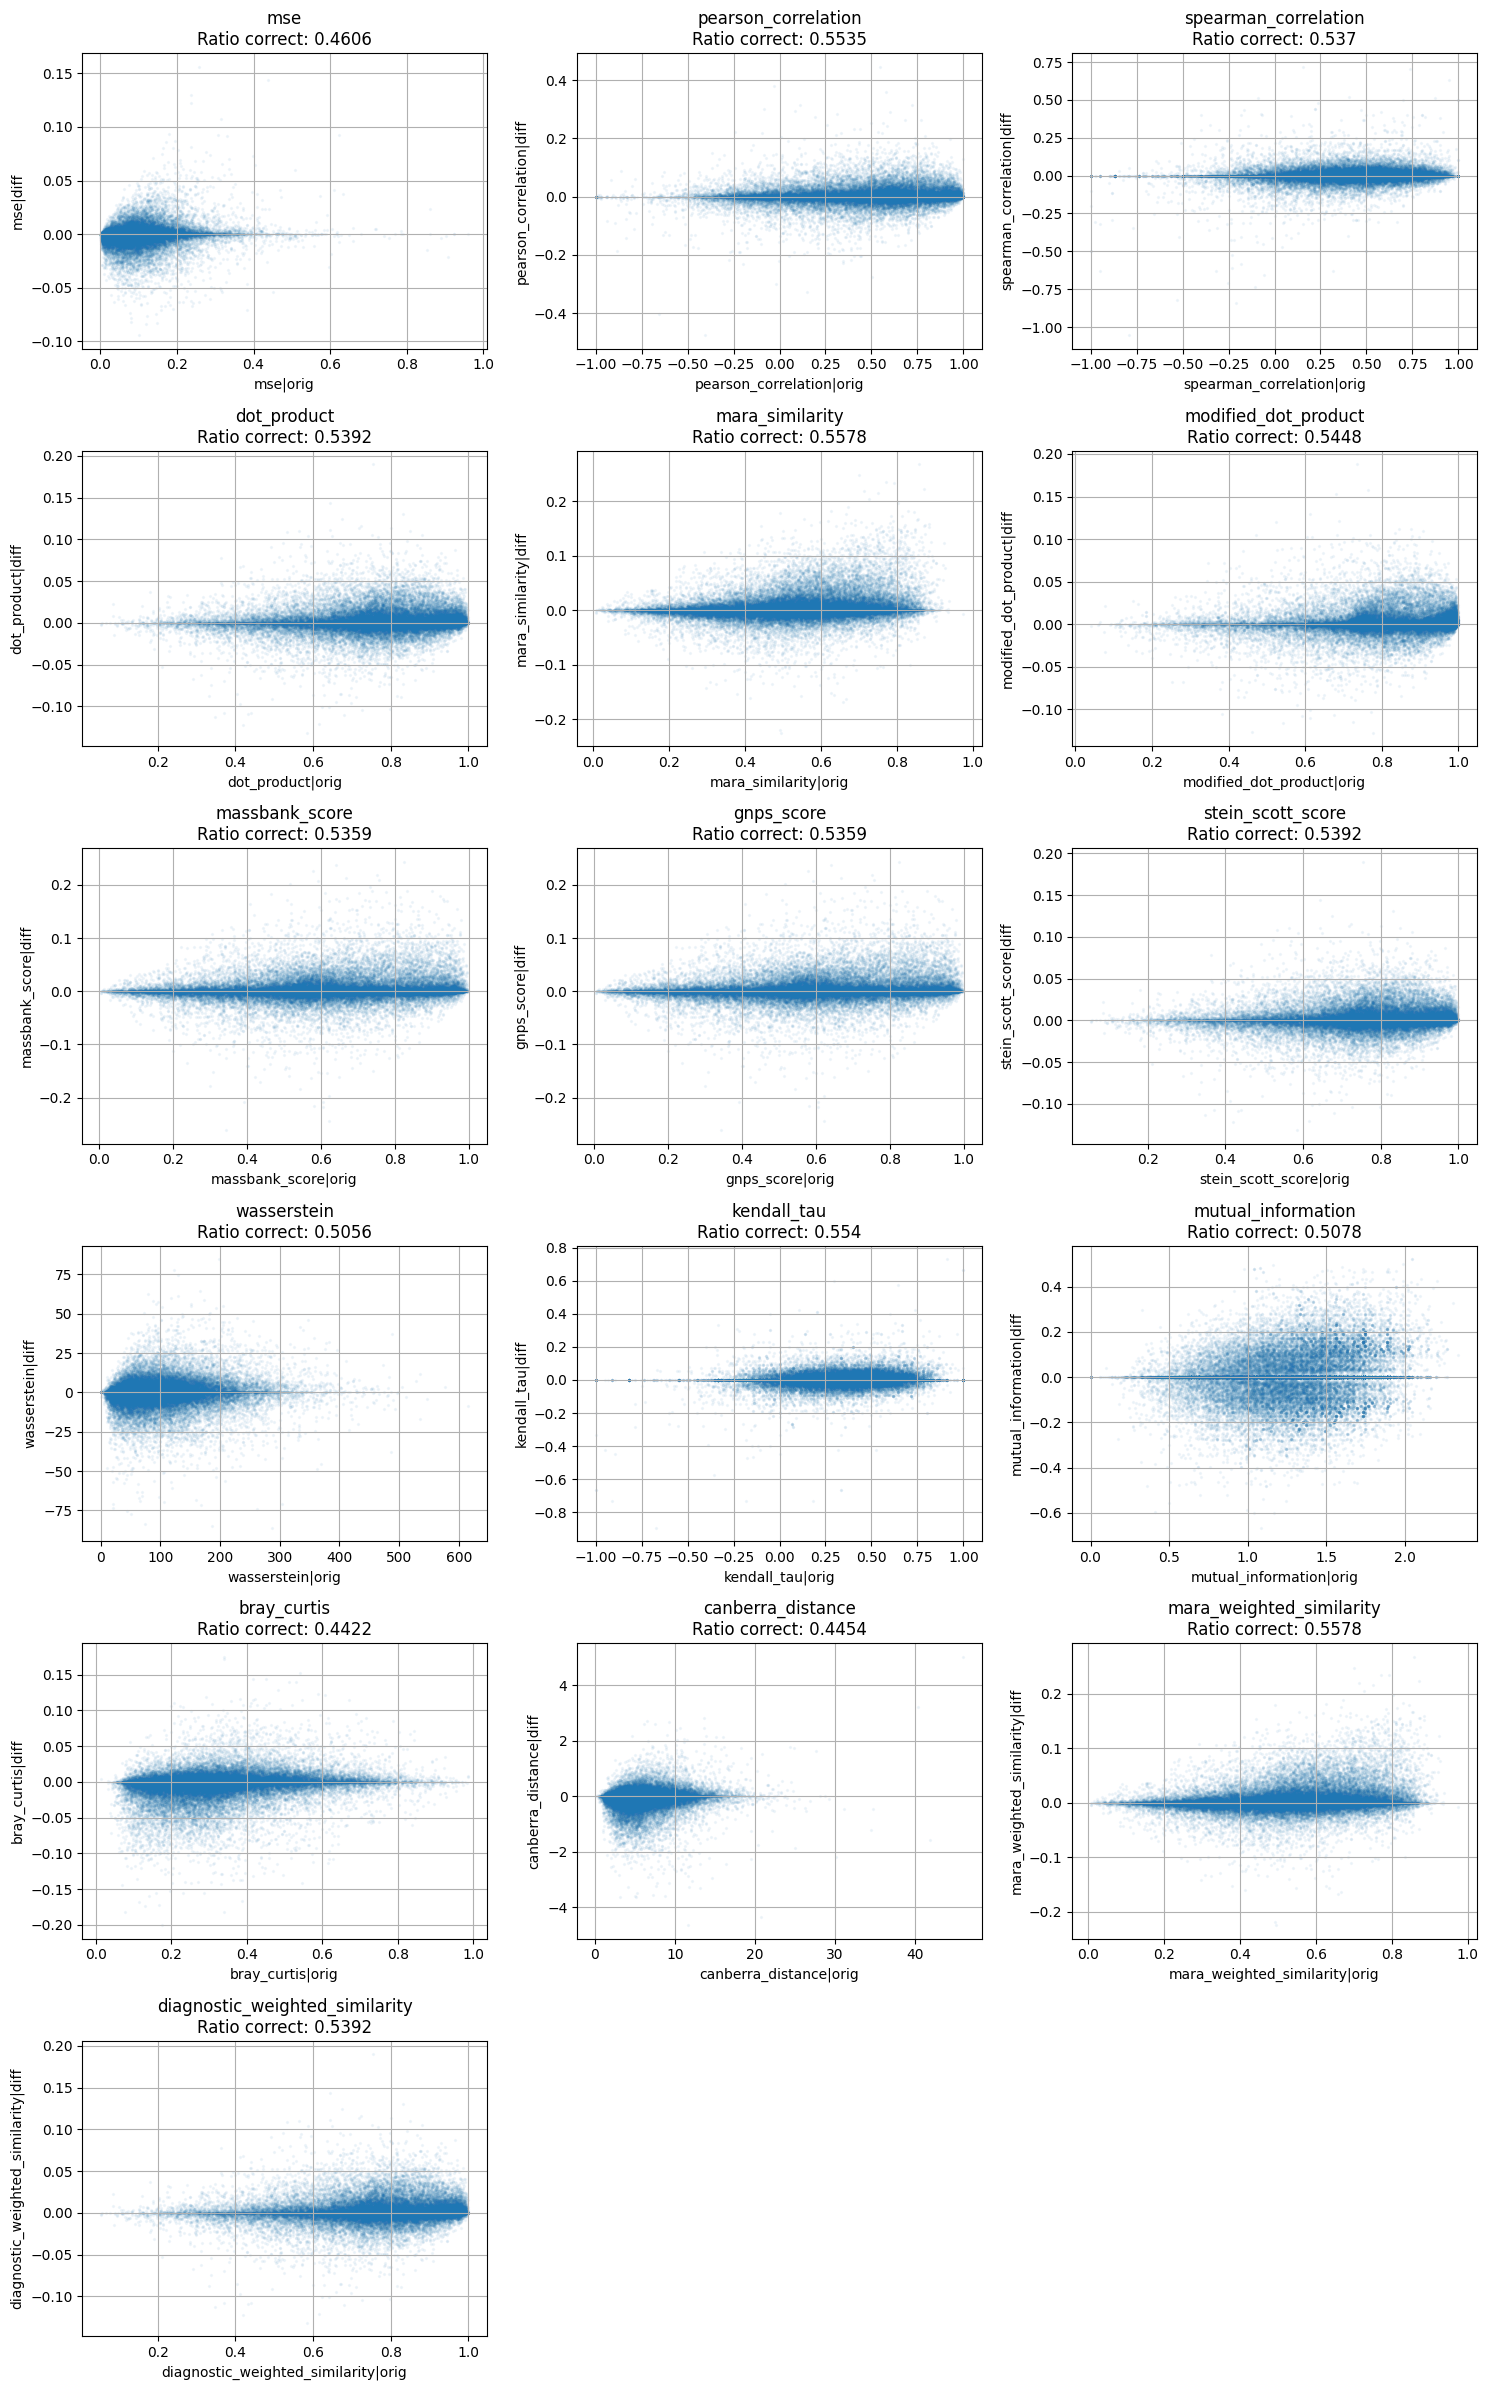

In [50]:
num_metrics = len(metric_keys)
cols = 3
rows = math.ceil(num_metrics / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten to easily index even if the grid has empty cells

for idx, metric_key in enumerate(metric_keys):
    scored_df_seqs[f"{metric_key}|diff"] = (
        scored_df_seqs[f"{metric_key}|orig"] - scored_df_seqs[f"{metric_key}|swapped"]
    )
    axes[idx].scatter(
        scored_df_seqs[f"{metric_key}|orig"],
        scored_df_seqs[f"{metric_key}|diff"],
        alpha=0.05,
        s=2
    )

    calc_ratio_correct = sum(scored_df_seqs[f"{metric_key}|diff"] > 0.0) / (sum(scored_df_seqs[f"{metric_key}|diff"] > 0.0) + sum(scored_df_seqs[f"{metric_key}|diff"] < 0.0))

    axes[idx].set_title(f"{metric_key}\nRatio correct: {round(calc_ratio_correct, 4)}")
    axes[idx].set_xlabel(f"{metric_key}|orig")
    axes[idx].set_ylabel(f"{metric_key}|diff")
    axes[idx].grid(True)

# Remove unused subplots if there are empty grid cells
for idx in range(num_metrics, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


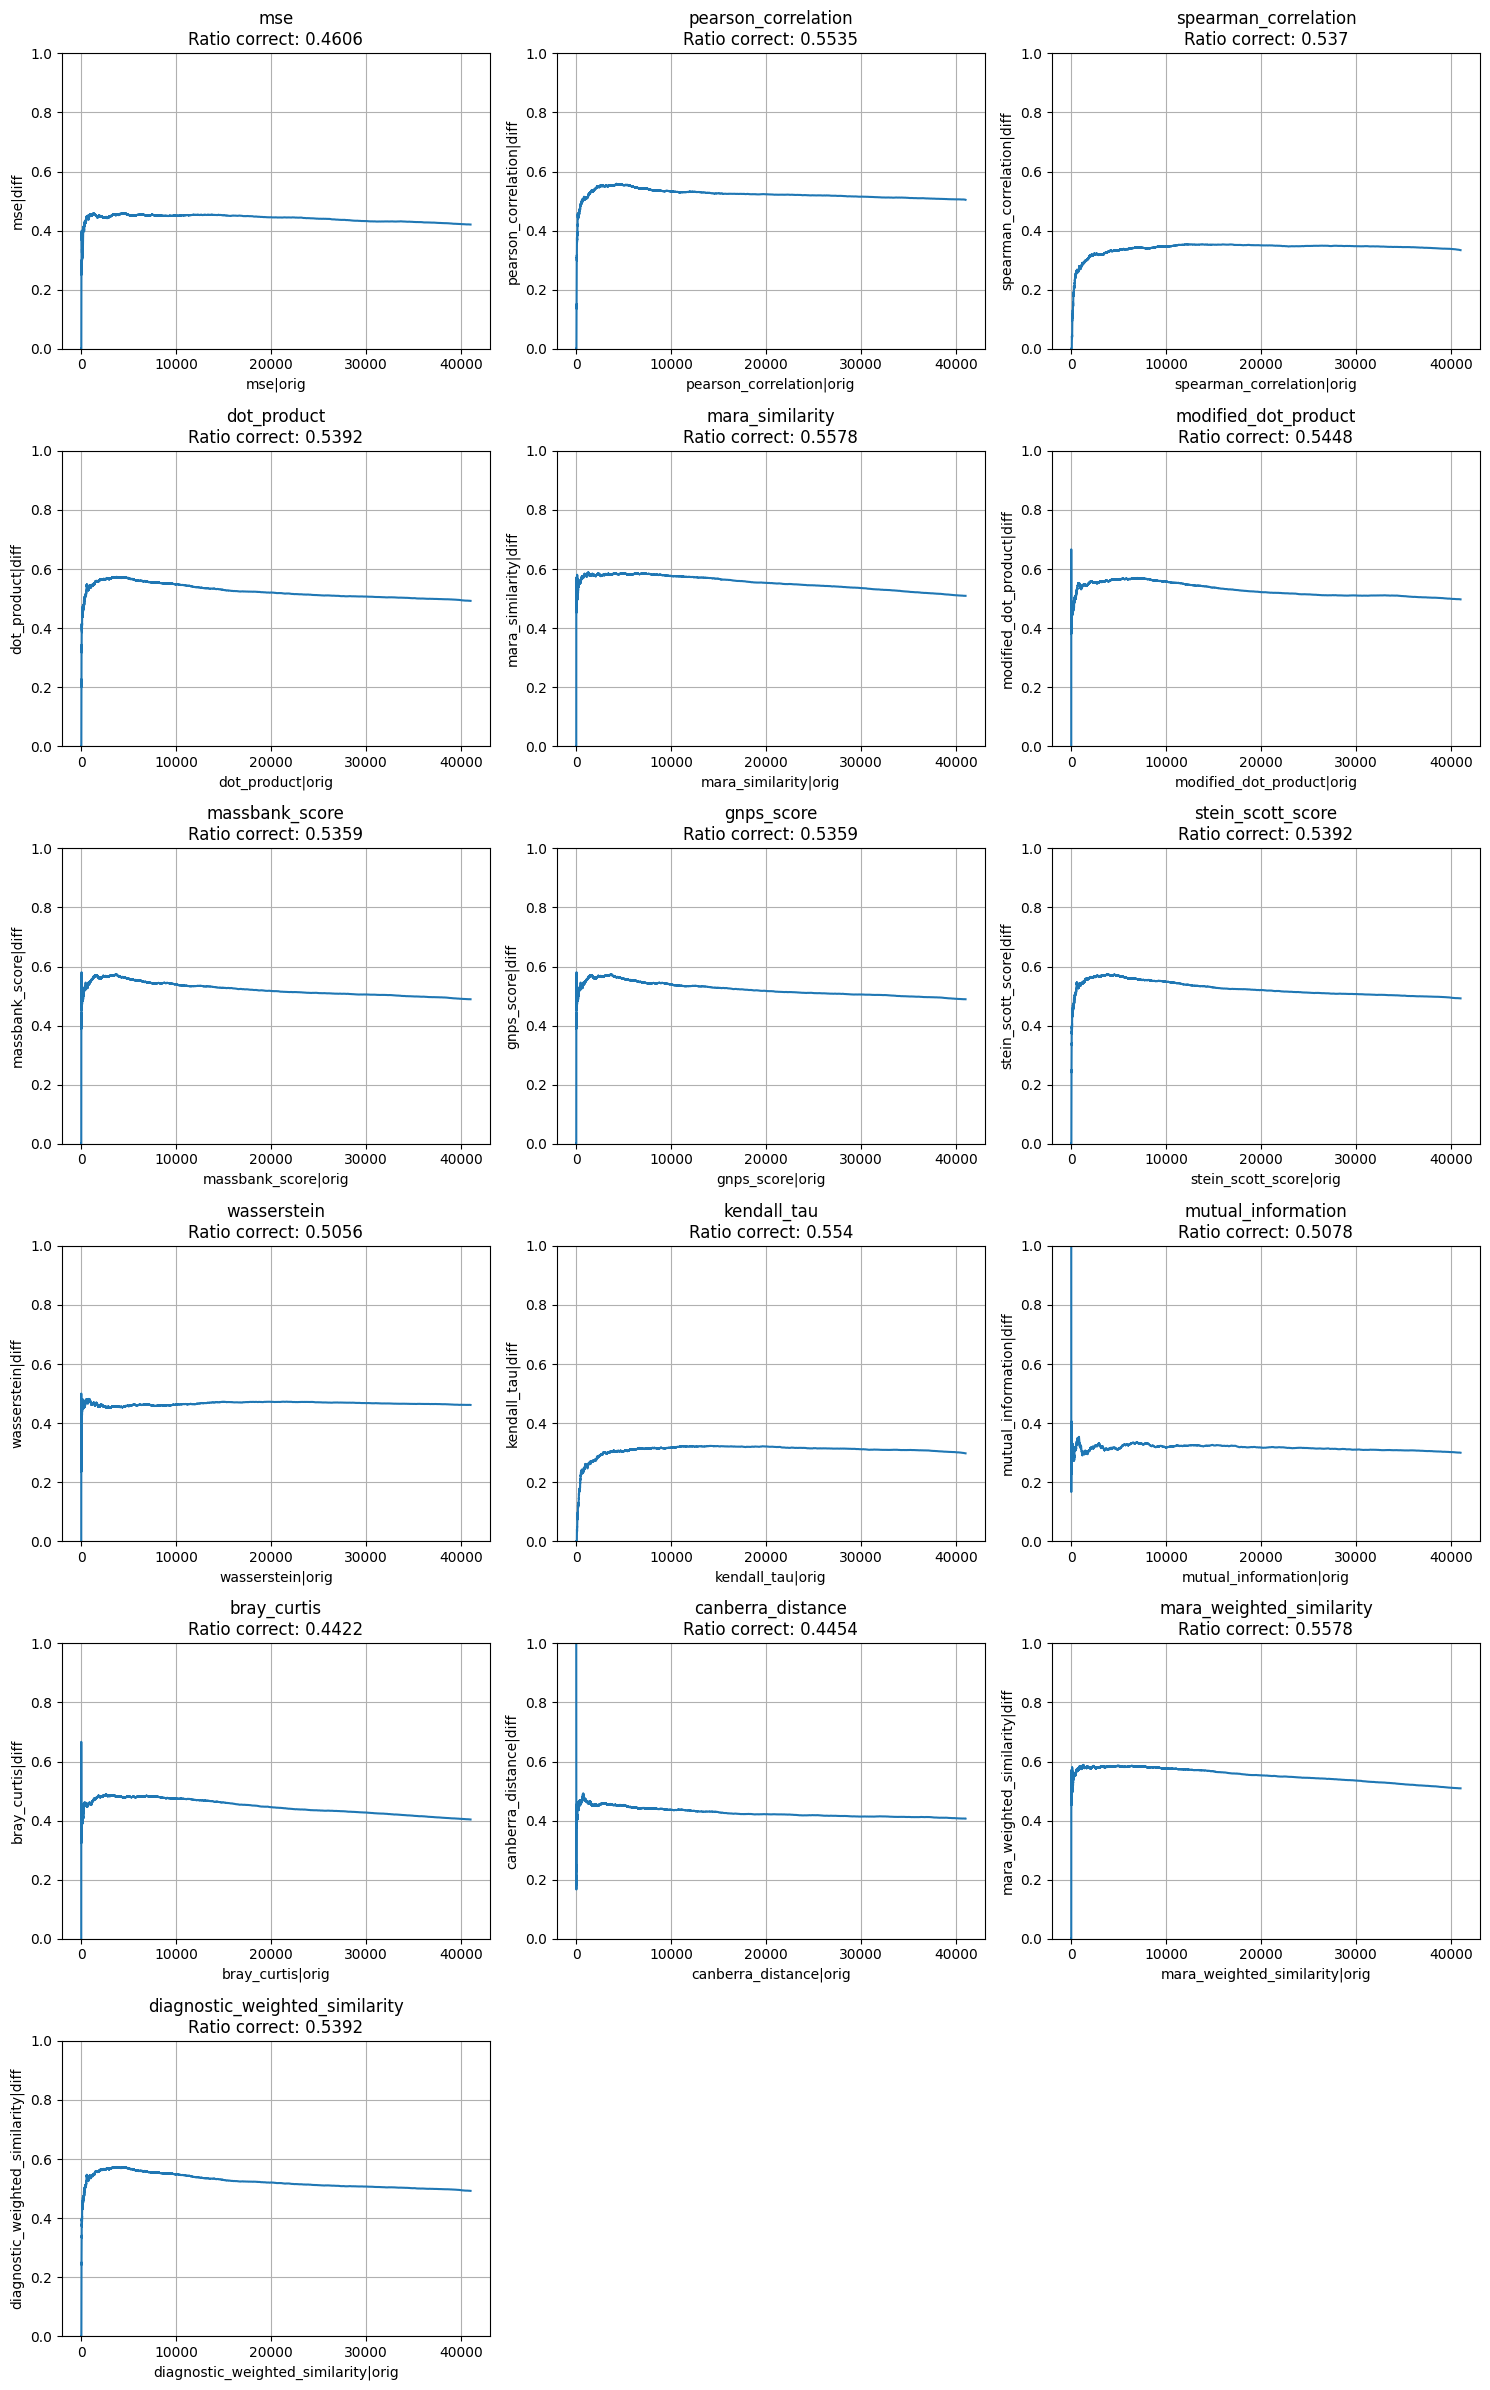

In [59]:
def calc_metric_acc(diff_arr):
    correct = 0
    total = 0
    acc_arr = []
    for v in diff_arr:
        total += 1
        if v > 0.0: correct += 1
        acc_arr.append(correct / total if total > 0 else 0.0)
    return acc_arr
        

num_metrics = len(metric_keys)
cols = 3
rows = math.ceil(num_metrics / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten to easily index even if the grid has empty cells

for idx, metric_key in enumerate(metric_keys):
    scored_df_seqs[f"{metric_key}|diff"] = (
        scored_df_seqs[f"{metric_key}|orig"] - scored_df_seqs[f"{metric_key}|swapped"]
    )

    scored_df_seqs[f"{metric_key}|avg"] = (
        (scored_df_seqs[f"{metric_key}|orig"] + scored_df_seqs[f"{metric_key}|swapped"]) / 2.0
    )

    
    acc_arr = calc_metric_acc(scored_df_seqs.sort_values(f"{metric_key}|avg",ascending=False)[f"{metric_key}|diff"])

    axes[idx].plot(
        range(len(scored_df_seqs[f"{metric_key}|orig"])),
        acc_arr,
    )
    
    axes[idx].set_ylim([0,1])    
    
    calc_ratio_correct = sum(scored_df_seqs[f"{metric_key}|diff"] > 0.0) / (sum(scored_df_seqs[f"{metric_key}|diff"] > 0.0) + sum(scored_df_seqs[f"{metric_key}|diff"] < 0.0))

    axes[idx].set_title(f"{metric_key}\nRatio correct: {round(calc_ratio_correct, 4)}")
    axes[idx].set_xlabel(f"{metric_key}|orig")
    axes[idx].set_ylabel(f"{metric_key}|diff")
    axes[idx].grid(True)

# Remove unused subplots if there are empty grid cells
for idx in range(num_metrics, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()
